In [1]:
from PIL import Image
from transformers import pipeline
import numpy as np
from pathlib import Path

import cv2

In [9]:
init()


Device set to use cpu


depth est. init


bottle
Average depth of the object: 132.75490909090908


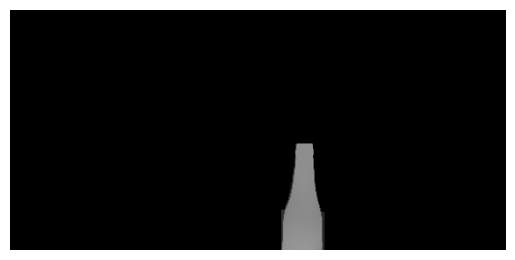

bottle
Average depth of the object: 91.06115498876893


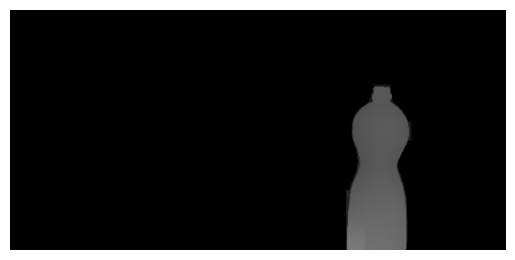

bottle
Average depth of the object: 198.23772363264612


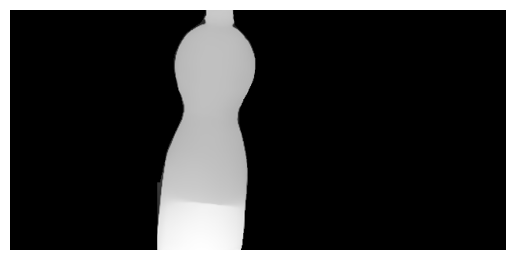

In [10]:
estimate(bottleFrameDetected, bottleBox, bottleMask, segmentResults)

In [3]:
from PIL import Image
from transformers import pipeline
import numpy as np

pipe = None

def init():
    global pipe
    pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
    print("depth est. init")

def calculateDepth(picam_array):
    pi_image = Image.fromarray(picam_array)
    # inference
    depth = pipe(pi_image)["depth"]
    depth.save("output/depth_estimation.png")

    # calculate the depth of the bottle
    # calculate average depth of pixels inside mask
    depth_array = np.array(depth)
    return depth_array

def estimate(picam_array, bottleBox, masks, res):
    # Iterate detection results 
    for r in res:
        img = np.copy(r.orig_img)
        img_name = Path(r.path).stem

        # Iterate each object contour 
        for ci, c in enumerate(r):
            label = c.names[c.boxes.cls.tolist().pop()]
            print(label)

            # just a full black mask
            b_mask = np.zeros(img.shape[:2], np.uint8)

            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

            # Choose one:

            # OPTION-1: Isolate object with black background
            mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR)
            # isolated = cv2.bitwise_and(mask3ch, img)

            depthImage = calculateDepth(picam_array)
            # print("Shape of mask3ch" ,mask3ch)
            # print("Shape of depth array", depthImage)

            # Convert depthImage to 3-channel image
            depthImage_3ch = cv2.cvtColor(depthImage, cv2.COLOR_GRAY2BGR)
            isolated = cv2.bitwise_and(mask3ch, depthImage_3ch)

            # Calculate the average depth value for the masked object
            masked_depth = cv2.bitwise_and(depthImage, depthImage, mask=b_mask)
            average_depth = cv2.mean(masked_depth, mask=b_mask)[0]
            print(f"Average depth of the object: {average_depth}")

            import matplotlib.pyplot as plt

            # Display the isolated object using matplotlib
            plt.imshow(cv2.cvtColor(isolated, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()





def estimate2(picam_array, bottleBox, masks, results):
    pi_image = Image.fromarray(picam_array)
    # inference
    depth = pipe(pi_image)["depth"]
    depth.save("output/depth_estimation.png")

    # calculate the depth of the bottle
    # calculate average depth of pixels inside mask
    depth_array = np.array(depth)

    b_mask = np.zeros(depth_array.shape[:2], np.uint8)


    contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
    _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
    average_depth = np.mean(contour)

    print(f"Average depth of the bottle: {average_depth}")

    return average_depth



In [2]:
import cv2
from picamera2 import Picamera2

from ultralytics import YOLO
from libcamera import Transform
import time

# from depthest import init, estimate

init


[308:36:47.414721077] [1711073]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[308:36:47.445836354] [1711276]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[308:36:47.447922166] [1711276]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media2 and ISP device /dev/media0
[308:36:47.447984573] [1711276]  INFO RPI pipeline_base.cpp:1120 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[308:36:47.458582428] [1711073]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x310-RGB888 (1) 1536x864-SGRBG10_CSI2P
[308:36:47.459028850] [1711276]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SGRBG10_1X10 - Selected unicam format: 1536x864-pgAA



0: 224x224 water_jug 0.12, pitcher 0.07, water_bottle 0.06, coffee_mug 0.06, paper_towel 0.05, 232.4ms
Speed: 31.3ms preprocess, 232.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
0
Bottle found with class index 898

0: 320x640 1 bottle, 807.7ms
Speed: 5.1ms preprocess, 807.7ms inference, 9.1ms postprocess per image at shape (1, 3, 320, 640)


Device set to use cpu


depth est. init
bottle
Average depth of the object: 89.68778689141395


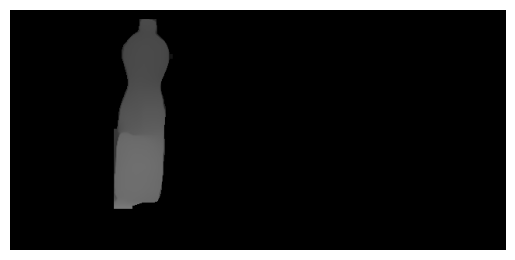

In [4]:

print("init")
with Picamera2() as picam2:
    # Initialize the Picamera2
    # picam2 = Picamera2()

    # default
    # picam2.preview_configuration.main.size = (1280, 720)
    picam2.preview_configuration.main.size = (640, 310)
    # picam2.preview_configuration.main.size = (640 /2, 310/2)

    picam2.preview_configuration.main.format = "RGB888"
    picam2.preview_configuration.align()
    picam2.preview_configuration.transform=Transform(vflip=1)
    picam2.configure("preview")
    picam2.start()


    # Load the YOLO11 model
    # have to run create model first 
    segmentModel = YOLO("yolo11n-seg.pt")  
    model = YOLO("yolo11n-cls.pt")

    instantBreak = False


    # used to record the time when we processed last frame 
    prev_frame_time = 0
    
    # used to record the time at which we processed current frame 
    new_frame_time = 0
    # font which we will be using to display FPS 
    font = cv2.FONT_HERSHEY_SIMPLEX 

    bottleFrameDetected = None
    bottleFrameNew = None

    results = None
    bottleBox = None

    while True:
        # time when we finish processing for this frame 
        # ! do all processing below this, and above the fps calculator
        new_frame_time = time.time() 

        # Capture frame-by-frame
        frame = picam2.capture_array()

        # Run YOLO11 inference on the frame
        results = model(frame)

        # print(results)
        # Visualize the results on the frame
        # annotated_frame = results[0].plot()

        new_frame_time = time.time() 
    
        # Calculating the fps 
        fps = 1/(new_frame_time-prev_frame_time) 
        prev_frame_time = new_frame_time 
        fps = int(fps) 
        fps = str(fps) 
        # cv2.putText(annotated_frame, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA) 
        print(fps)
        # Check if a bottle has been recognized
        for result in results:
            # probs = result.probs  # Probs object for classification outputs
            # print(probs)
            # classification model
            if result.probs != None:
                # print("Top 5 classes", result.probs.top5)
                # https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
                # 440: beer_bottle
                # 898: water bottle
                if 898 in result.probs.top5:
                    print("Bottle found with class index 898")
                    bottleFrameDetected = frame
                    instantBreak = True
                    break;


            # for detection in result.boxes:
            # #     # Assuming detection.cls is an integer index for the class
            #     bottleBox = detection
            #     if detection.cls == 39:  # correct class index for "bottle"
            #         print("Bottle recognized", )
            #         print("Probabilty", detection.conf)
            #         bottleFrameDetected = frame
            #         instantBreak = True
            #         break


        # Display the resulting frame
        # cv2.imshow("Camera", annotated_frame)

        if instantBreak:
            break
        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) == ord("q"):
            print("")
            break

    # Release resources and close windows
    cv2.destroyAllWindows()

    # https://docs.ultralytics.com/modes/predict/#__tabbed_1_1
    if bottleFrameDetected is not None:
        # Capture a new frame of the bottle
        # should not be blurry
        bottleFrameNew = picam2.capture_array()
        cv2.imwrite("output/bottle_new.png", bottleFrameNew)

    # Process results list
    # results for bottleFrameDetected
    for result in results:
        boxes = result.boxes  # Boxes object for bounding box outputs
        masks = result.masks  # Masks object for segmentation masks outputs
        keypoints = result.keypoints  # Keypoints object for pose outputs
        probs = result.probs  # Probs object for classification outputs
        obb = result.obb  # Oriented boxes object for OBB outputs
        # result.show()  # display to screen
        result.save(filename="output/bottle_detected.png")  # save to disk

    # segmnet
    segmentResults = segmentModel.predict(source=bottleFrameDetected, classes=39)
    bottleMask = None
    # Process results list
    for result in segmentResults:
        result.save(filename="output/segmented.jpg")  # save to disk

        if (result.masks.shape[0] > 1) :
            print("Error! More than one bottle detected. Using the first one.")
            print("Error! More than one bottle detected. Using the first one.")
            print("Error! More than one bottle detected. Using the first one.")

        bottleMask = result.masks[0]  # Masks object for segmentation masks outputs

    init()
    estimate(bottleFrameDetected, bottleBox, bottleMask, segmentResults)




# Stop the camera to free up resources
picam2.stop() 
picam2.stop_encoder()

del picam2
